# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写



In [219]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm import tqdm

In [2]:
#参数配置

config = {
    "data_path":'criteo.csv',
    "sparse_cols":[f'C{x}' for x in range(1,27)],
    "dense_cols" : [f'I{x}' for x in range(1,14)],
    "train_ratio" : 0.7,
    "valid_ratio" : 0.2,
    "debug_mode" : True,
    "epoch" : 5,
    "batch" : 10240,
    "lr" : 0.0001,
    "device" : -1,
}

In [3]:
df = pd.read_csv(config['data_path'])

In [4]:
if config['debug_mode']:
    df = df[:1000]
df[config['sparse_cols']] = df[config['sparse_cols']].fillna('-1', )
df[config['dense_cols']] = df[config['dense_cols']].fillna(0, )
train_num = int(len(df)*config['train_ratio'])
valid_num = int(len(df)*config['valid_ratio'])
#切分数据集
train_df = df[:train_num].reset_index(drop=True)
valid_df = df[train_num:train_num+valid_num].reset_index(drop=True)
test_df = df[train_num+valid_num:].reset_index(drop=True)

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O




In [8]:
#Dataset构造
class BaseDataset(Dataset):
    def __init__(self,config,df,enc_dict=None):
        self.config = config
        self.df = df
        self.enc_dict = enc_dict
        self.dense_cols = list(set(self.config['dense_cols']))
        self.sparse_cols = list(set(self.config['sparse_cols']))
        self.feature_name = self.dense_cols+self.sparse_cols+['label']

        #数据编码
        if self.enc_dict == None:
            self.get_enc_dict()
        self.enc_data()

    def get_enc_dict(self):
        #计算enc_dict
        self.enc_dict = dict(zip( list(self.dense_cols+self.sparse_cols),[dict() for _ in range(len(self.dense_cols+self.sparse_cols))]))
        for f in self.sparse_cols:
            self.df[f] = self.df[f].astype('str')
            map_dict = dict(zip(self.df[f].unique(), range(1,self.df[f].nunique()+1)))
            self.enc_dict[f] = map_dict
            self.enc_dict[f]['vocab_size'] = self.df[f].nunique()+1
            '''
            eg:C17 特征的map_dict
            {'e5ba7672': 1,
             '07c540c4': 2,
             '8efede7f': 3,
             '1e88c74f': 4,
             '776ce399': 5,
             'd4bb7bd8': 6,
             '3486227d': 7,
             '27c07bd6': 8,
             '2005abd1': 9,
             'vocab_size': 10}
            '''

        for f in self.dense_cols:
            self.enc_dict[f]['min'] = self.df[f].min()
            self.enc_dict[f]['max'] = self.df[f].max()
            '''
            eg:I6 特征
            {'min': 0.0, 'max': 4638.0}
            '''
        return self.enc_dict

    def enc_dense_data(self,col):
        return (self.df[col] - self.enc_dict[col]['min']) / (self.enc_dict[col]['max'] - self.enc_dict[col]['min'])

    def enc_sparse_data(self,col):
        return self.df[col].apply(lambda x : self.enc_dict[col].get(x,0))

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_df = copy.deepcopy(self.df)
        for col in self.dense_cols:
            self.enc_df[col] = self.enc_dense_data(col)
        for col in self.sparse_cols:
            self.enc_df[col] = self.enc_sparse_data(col)

    def __getitem__(self, index):
        data = dict()
        for col in self.feature_name:
            if col in self.dense_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).squeeze(-1)
            elif col in self.sparse_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).long().squeeze(-1)
        data['label'] = torch.Tensor([self.enc_df['label'].iloc[index]]).squeeze(-1)
        return data

    def __len__(self):
        return len(self.enc_df)

In [9]:
train_dataset = BaseDataset(config,train_df)
enc_dict = train_dataset.get_enc_dict()

valid_dataset = BaseDataset(config,valid_df,enc_dict=enc_dict)
test_dataset = BaseDataset(config,test_df,enc_dict=enc_dict)

In [10]:
train_dataset.__getitem__(5)

{'I4': tensor(0.),
 'I5': tensor(0.0144),
 'I12': tensor(0.),
 'I6': tensor(0.),
 'I10': tensor(0.),
 'I9': tensor(0.0011),
 'I1': tensor(0.),
 'I13': tensor(0.),
 'I3': tensor(0.),
 'I2': tensor(0.),
 'I8': tensor(0.),
 'I11': tensor(0.),
 'I7': tensor(0.),
 'C5': tensor(2),
 'C12': tensor(6),
 'C6': tensor(4),
 'C24': tensor(6),
 'C1': tensor(4),
 'C23': tensor(3),
 'C11': tensor(6),
 'C4': tensor(6),
 'C3': tensor(6),
 'C18': tensor(6),
 'C16': tensor(6),
 'C17': tensor(5),
 'C19': tensor(2),
 'C7': tensor(6),
 'C9': tensor(1),
 'C13': tensor(6),
 'C8': tensor(2),
 'C22': tensor(3),
 'C14': tensor(3),
 'C10': tensor(3),
 'C20': tensor(3),
 'C25': tensor(2),
 'C26': tensor(3),
 'C2': tensor(6),
 'C15': tensor(6),
 'C21': tensor(6),
 'label': tensor(0.)}

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

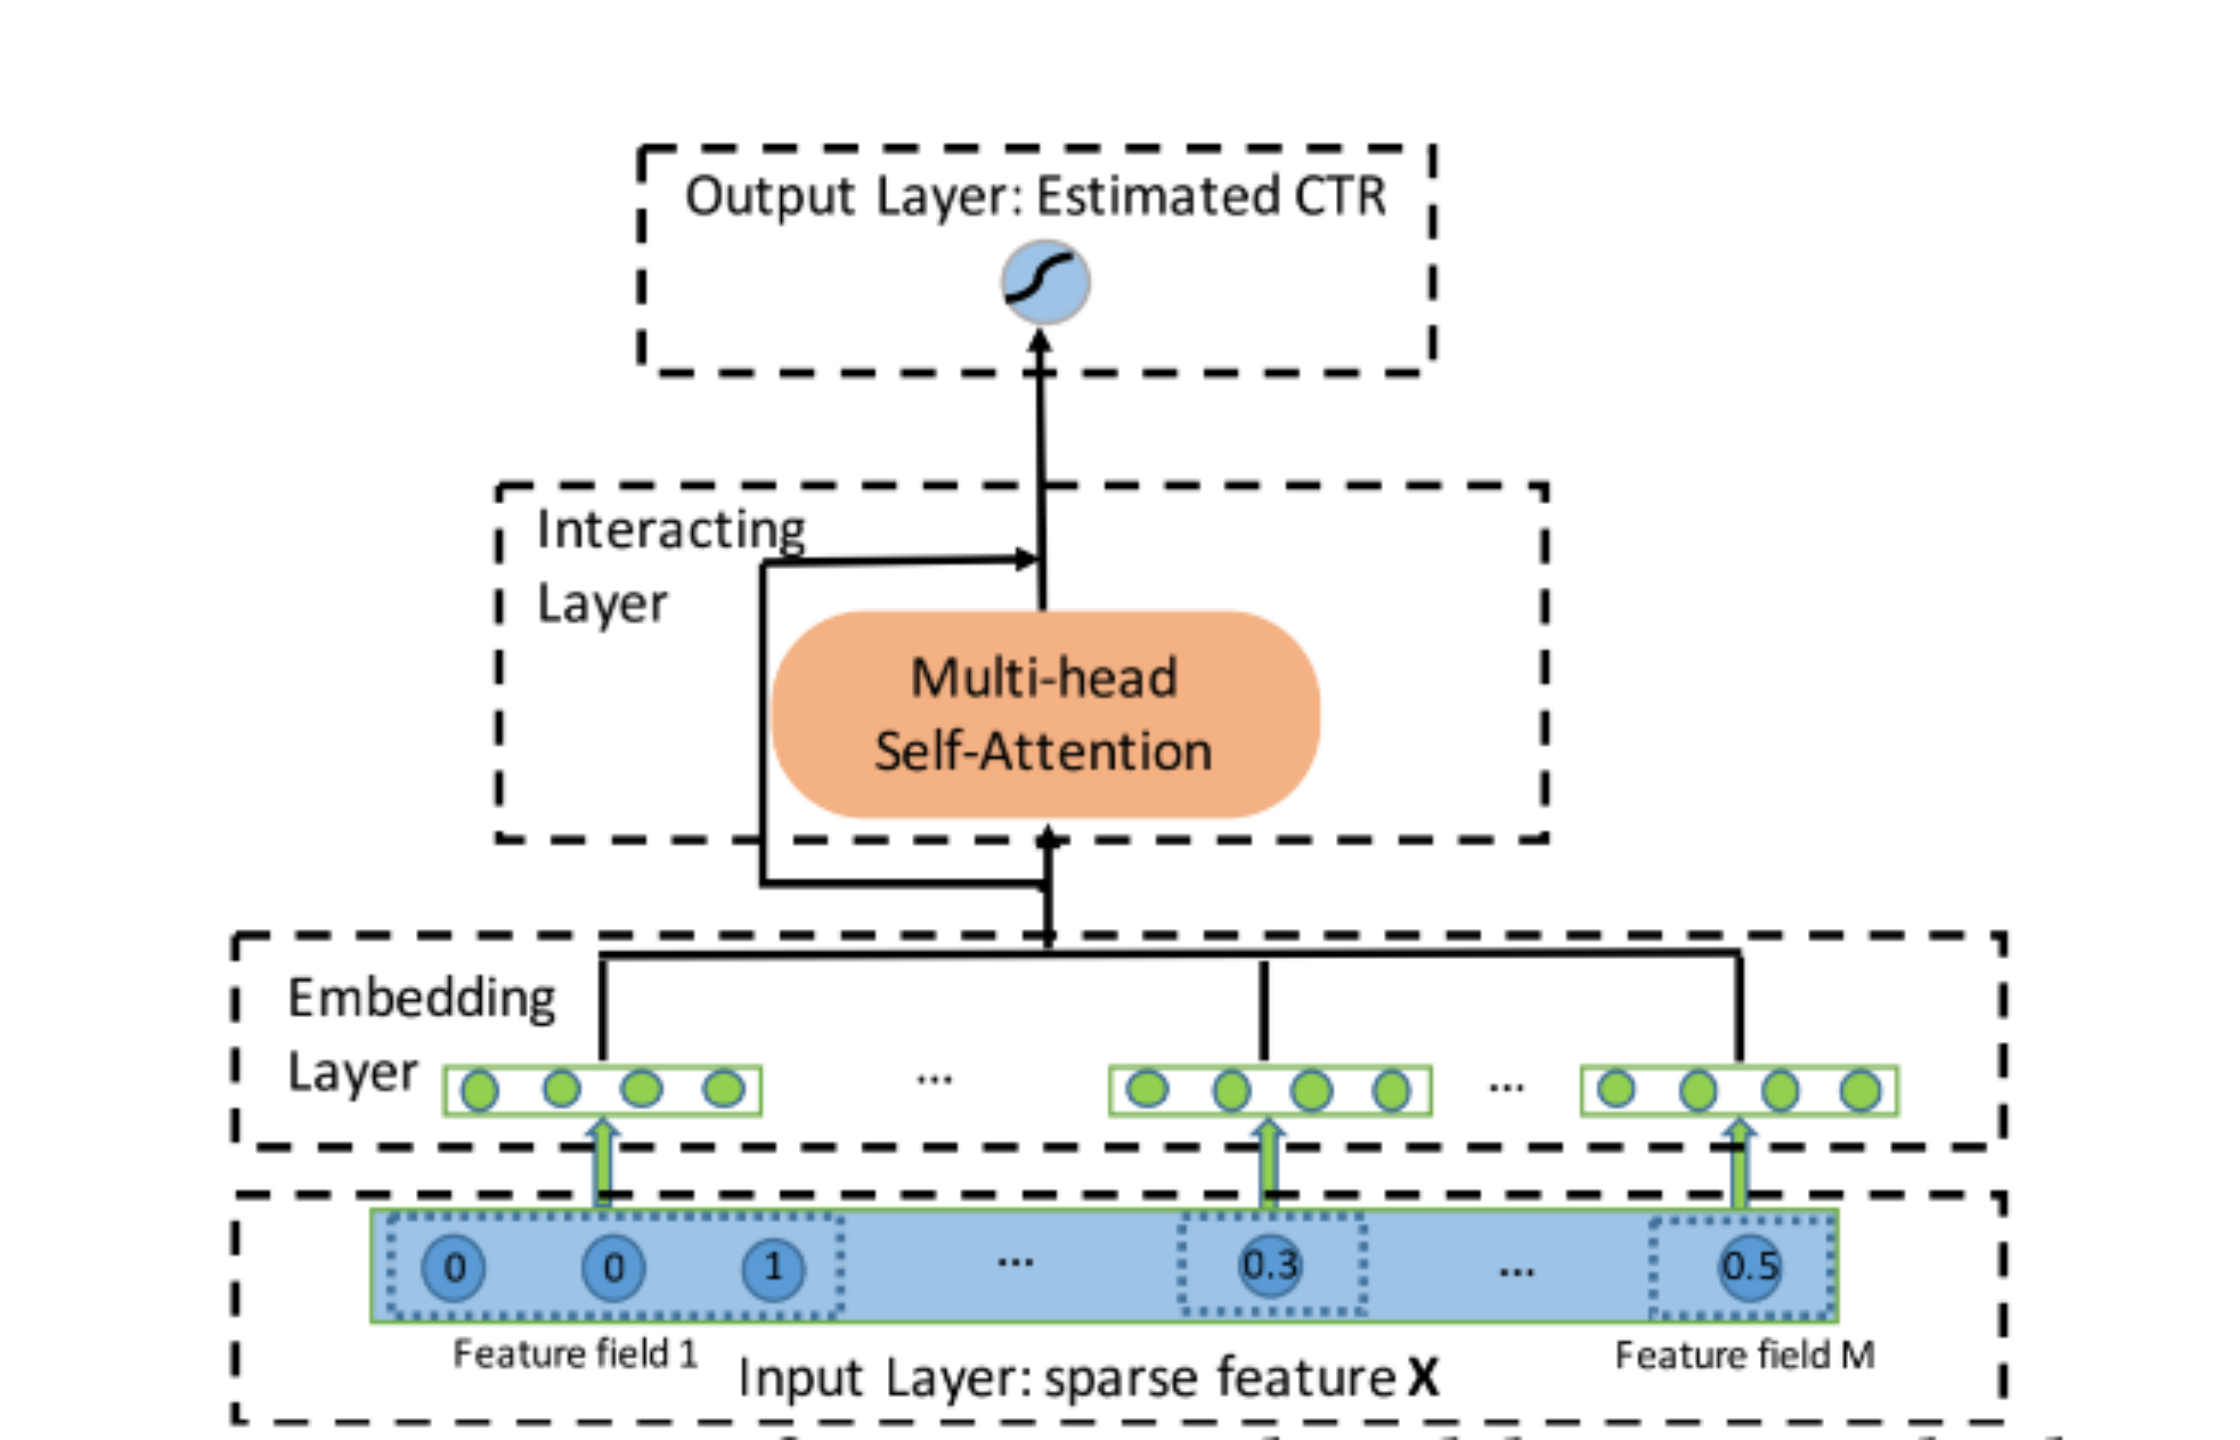

In [100]:
#基本网络模块

#通用Emb

class EmbeddingLayer(nn.Module):
    def __init__(self,
                 enc_dict = None,
                 embedding_dim = None):
        super(EmbeddingLayer, self).__init__()
        self.enc_dict = enc_dict
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.ModuleDict()

        self.emb_feature = []

        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col].keys():
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Embedding(
                    self.enc_dict[col]['vocab_size'],
                    self.embedding_dim,
                )})

    def forward(self, X):
        #对所有的sparse特征挨个进行embedding
        feature_emb_list = []
        for col in self.emb_feature:
            inp = X[col].long().view(-1, 1)
            feature_emb_list.append(self.embedding_layer[col](inp))
        return feature_emb_list
    

class EmbeddingLayerV2(nn.Module):
    def __init__(self,
                 enc_dict = None,
                 embedding_dim = None):
        super(EmbeddingLayerV2, self).__init__()
        self.enc_dict = enc_dict
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.ModuleDict()

        self.emb_feature = []

        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col].keys():
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Embedding(
                    self.enc_dict[col]['vocab_size'],
                    self.embedding_dim,
                )})
            else:
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Linear(1,self.embedding_dim)
                })

    def forward(self, X):
        #对所有的sparse特征挨个进行embedding
        feature_emb_list = []
        for col in self.emb_feature:
            inp = X[col].view(-1, 1)
            feature_emb_list.append(self.embedding_layer[col](inp).squeeze(1))
        return feature_emb_list
    
#一阶交叉
class LR_Layer(nn.Module):
    def __init__(self,enc_dict):
        super(LR_Layer, self).__init__()
        self.enc_dict = enc_dict
        self.emb_layer = EmbeddingLayer(enc_dict=self.enc_dict,embedding_dim=1)
        self.dnn_input_dim = get_dnn_input_dim(self.enc_dict, 1)
        self.fc = nn.Linear(self.dnn_input_dim,1)
        
    def forward(self,data):
        sparse_emb = self.emb_layer(data)
        sparse_emb = torch.stack(sparse_emb,dim=1).flatten(1) #[batch,num_sparse*emb]
        dense_input = get_linear_input(self.enc_dict, data)  #[batch,num_dense]
        dnn_input = torch.cat((sparse_emb, dense_input), dim=1) # [batch,num_sparse*emb + num_dense]
        out = self.fc(dnn_input)
        return out
    

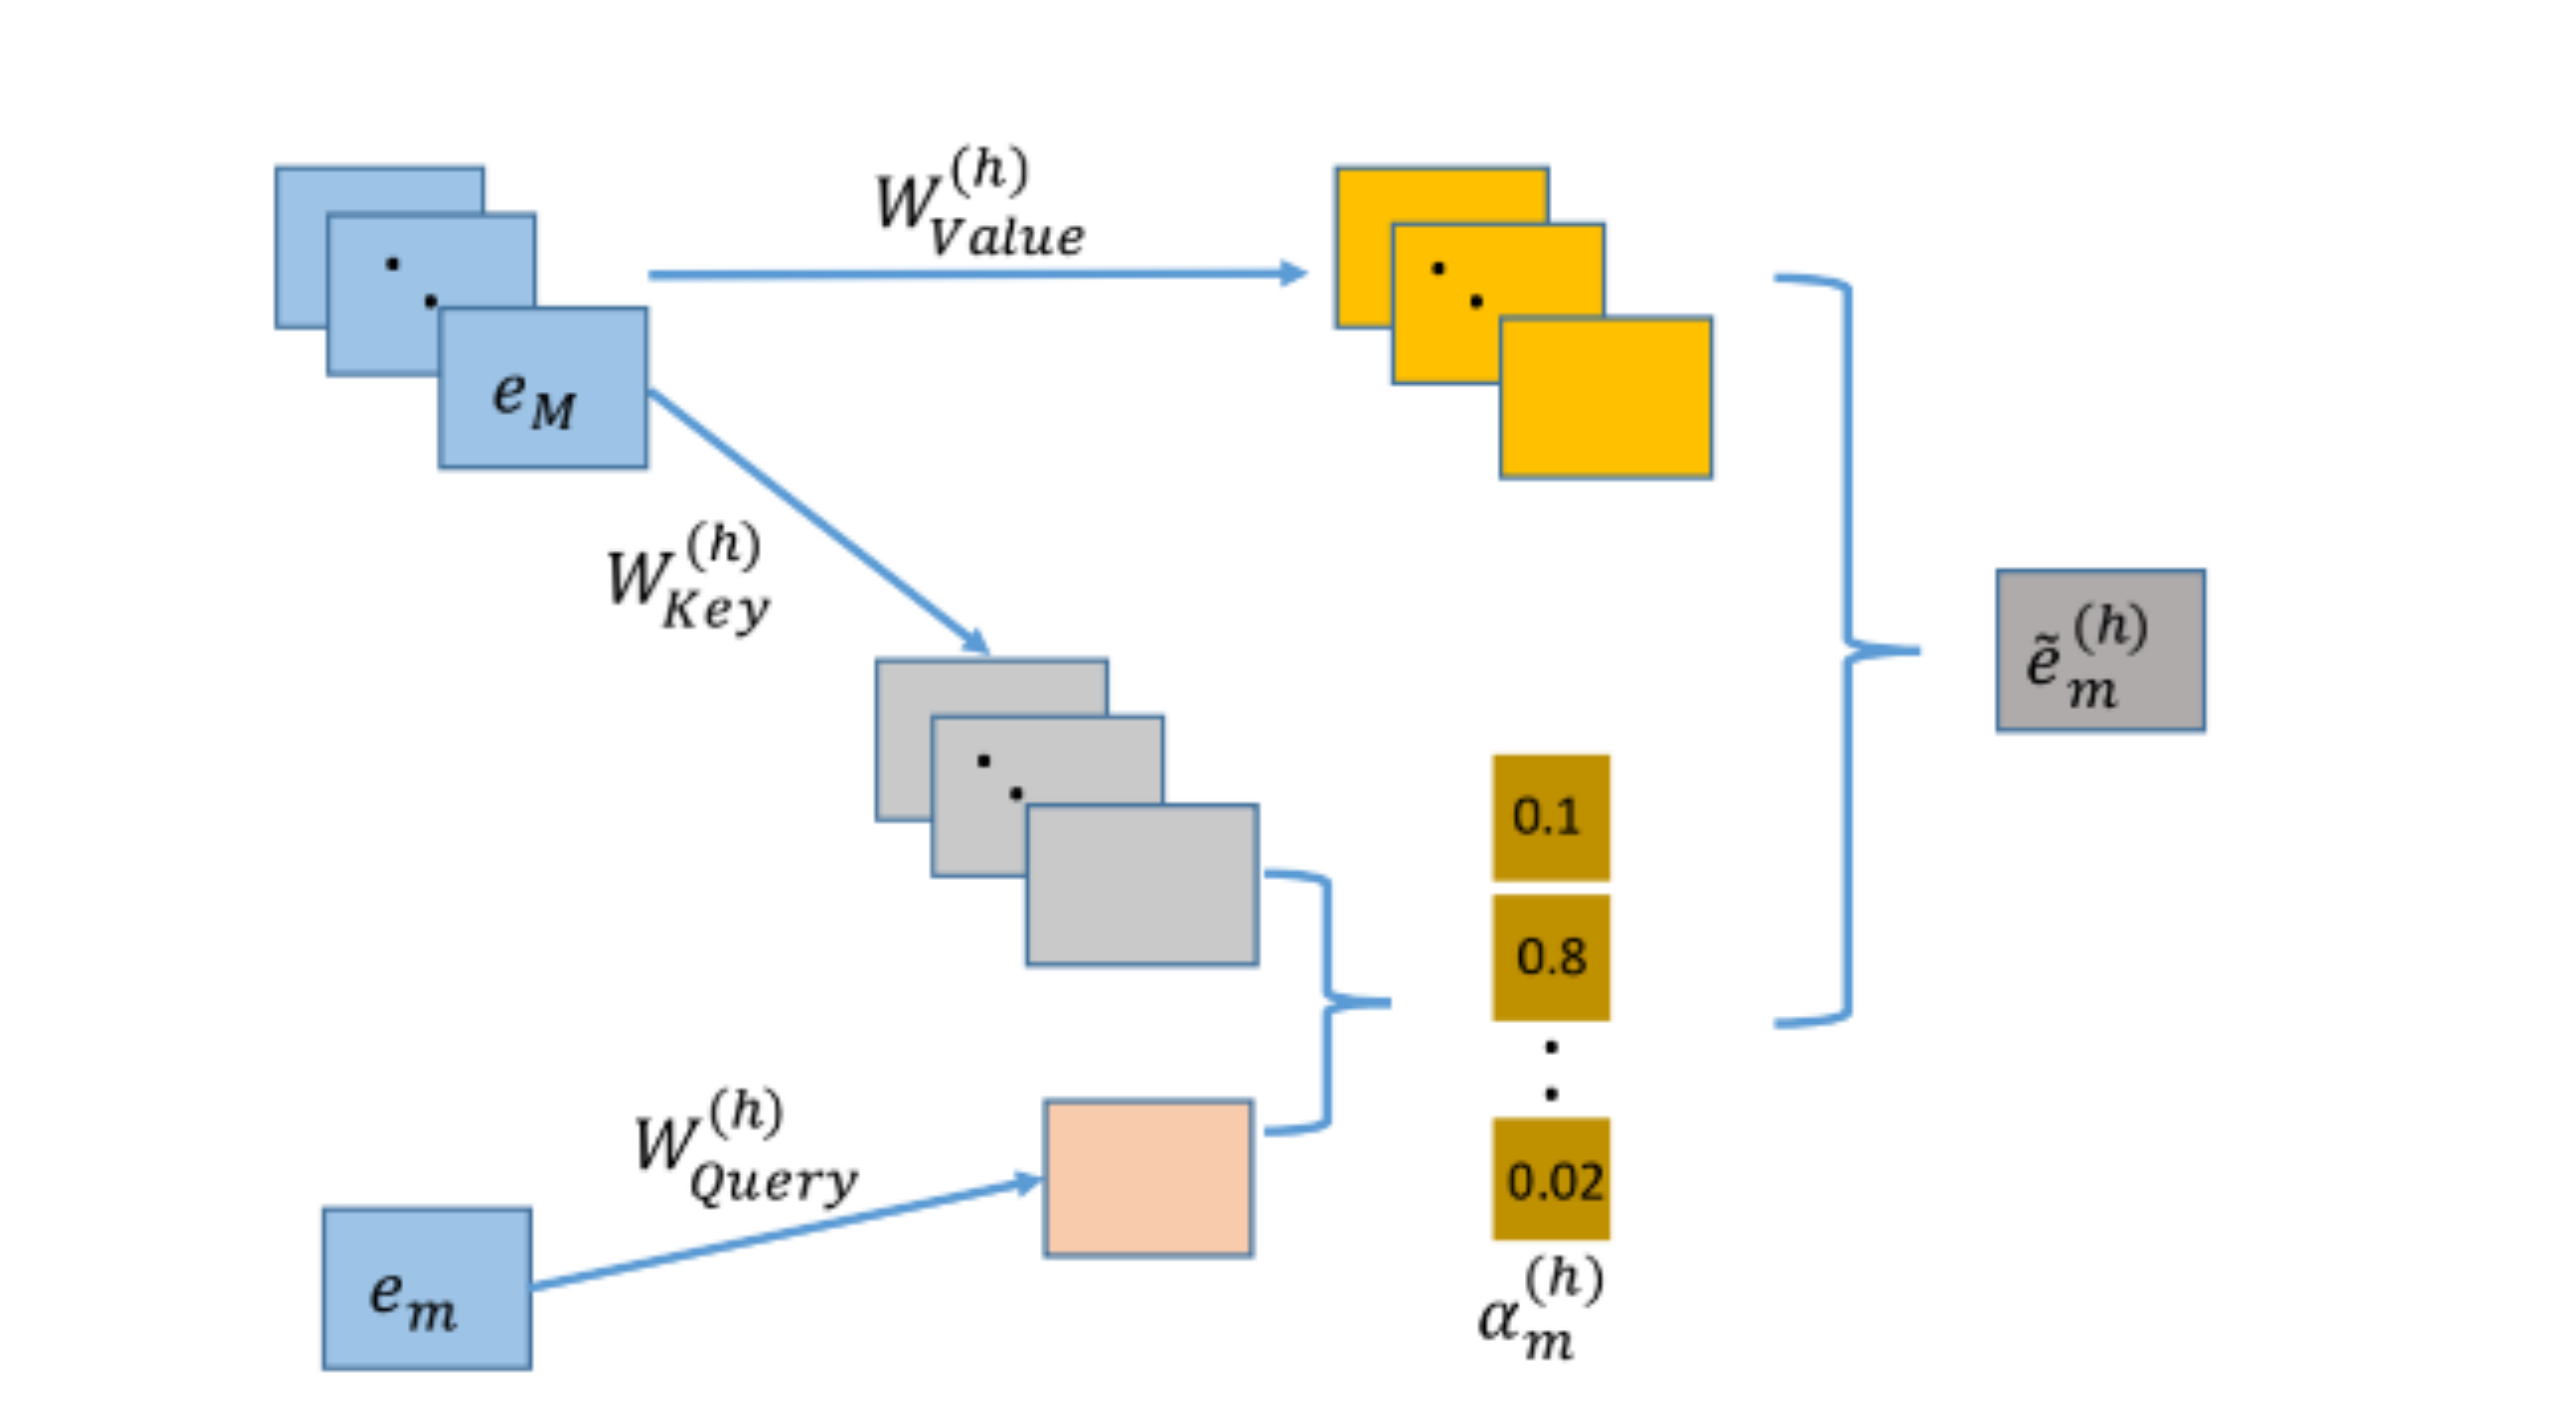

In [ ]:
# 1.单个特征attention score计算的矩阵化加速：em:[1,d'] E:[M,d'] em*E.T->[1,M]
# 2.所有特征的attention score计算的矩阵化加速： E:[M,d'] E:[M,d'] E*E.T -> [M,M]

In [202]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, attention_dim=10, num_heads=4):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.attention_dim = attention_dim
        self.num_heads = num_heads
        
        self.output_dim = self.attention_dim * self.num_heads
        
        self.Q = nn.Linear(self.input_dim, self.output_dim, bias=False)
        self.K = nn.Linear(self.input_dim, self.output_dim, bias=False)
        self.V = nn.Linear(self.input_dim, self.output_dim, bias=False)
        self.res_W = nn.Linear(self.input_dim, self.output_dim, bias=False)
        
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, X):
        X = X[0]
        query = self.Q(X)
        key = self.K(X)
        value = self.V(X) #query,key,value : [batch,num_feature,num_heads*attention_dim]

        batch_size = query.size(0)
        query = query.view(batch_size * self.num_heads, -1, self.attention_dim)
        key = key.view(batch_size * self.num_heads, -1, self.attention_dim)
        value = value.view(batch_size * self.num_heads, -1, self.attention_dim) # query,key,value : [batch*num_heads,num_feature,attention_dim]
        
        
        # 每一个query的emb都需要和所有的key的emb进行两两内积，这一过程可以通过 Q*K.T 来进行向量化加速
        attention_score = torch.bmm(query, key.transpose(1,2)) #[batch*num_heads, num_feature, num_feature]
        attention_score = self.softmax(attention_score)
        # 通过attention_score重新给原始的value进行加权
        output = torch.bmm(attention_score, value) #[batch*num_heads, num_feature, attention_dim]
        output = output.view(batch_size, -1, self.output_dim) #[batch, num_feature, num_heads*attention_dim]
        
        # 残差连接
        output = output + self.res_W(X)
        output = output.relu()
        
        return output, attention_score

In [221]:
# test
sample_batch = 16
sample_num_feature = 8
sample_emb_dim = 32
sample_num_heads = 4
sample_attention_dim = 16

attention_net = MultiHeadAttention(input_dim=sample_emb_dim,
                                   num_heads=sample_num_heads,
                                   attention_dim=sample_attention_dim)
sample_input = torch.rand(sample_batch,sample_num_feature,sample_emb_dim)
output, attention_score = attention_net([sample_input])
output.shape,attention_score.shape

(torch.Size([16, 8, 64]), torch.Size([64, 8, 8]))

In [204]:
#DNN
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_dnn_input_dim(enc_dict,embedding_dim):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse*embedding_dim+num_dense

def get_linear_input(enc_dict,data):
    res_data = []
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            res_data.append(data[col])
    res_data = torch.stack(res_data,axis=1)
    return res_data

In [205]:
#Autolnt 模型
class Autolnt(nn.Module):
    def __init__(self,
                 embedding_dim = 16,
                 attention_dim = 8,
                 num_heads = 4,
                 num_attention_layer = 2,
                 hidden_units=[64, 64, 64],
                 loss_fun = 'torch.nn.BCELoss()',
                 enc_dict=None):
        super(Autolnt, self).__init__()

        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim
        self.num_heads = num_heads
        self.num_attention_layer  = num_attention_layer
        self.hidden_units = hidden_units
        self.loss_fun = eval(loss_fun)
        self.enc_dict = enc_dict

        self.embedding_layer = EmbeddingLayerV2(enc_dict=self.enc_dict, embedding_dim=self.embedding_dim)
        
        self.lr = LR_Layer(enc_dict=enc_dict) #一阶
        self.attention_net = nn.Sequential(
            *[MultiHeadAttention(input_dim = self.embedding_dim if i==0 else self.num_heads*self.attention_dim,
                               num_heads = self.num_heads,
                               attention_dim = self.attention_dim) for i in range(self.num_attention_layer)]
        )

        self.dnn_input_dim = len(self.enc_dict) * self.attention_dim * self.num_heads

        self.dnn = MLP_Layer(input_dim=self.dnn_input_dim, output_dim=1, hidden_units=self.hidden_units,
                                 hidden_activations='relu', dropout_rates=0)
    
#     def get_attention_score(self):
#         pass
    
    def forward(self, data):
        sparse_embedding = self.embedding_layer(data)
        feature_embedding = torch.stack(sparse_embedding, dim=1)
        
        # 一阶特征交叉
        lr_logit = self.lr(data) #一阶交叉
        
        # MultiHeadAttention
        attention_output,attention_score = self.attention_net([feature_embedding])
        attention_output = torch.flatten(attention_output, start_dim=1)
        attention_logit = self.dnn(attention_output)
        
        #输出
        y_pred = torch.sigmoid(lr_logit + attention_logit)
        loss = self.loss_fun(y_pred.squeeze(-1),data['label'])
        output_dict = {'pred':y_pred,'loss':loss,'attention_score':attention_score.detach().cpu().numpy()}
        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [222]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

In [223]:
#dataloader
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=0)
valid_loader = D.DataLoader(valid_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

In [224]:
model = Autolnt(enc_dict=enc_dict)

In [225]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)
    #模型验证
    valid_metric = valid_model(model,valid_loader,device)

    print("Train Metric:")
    print(train_metirc)
    print("Valid Metric:")
    print(valid_metric)
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

Loss 0.7816579937934875: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Train Metric:
{'roc_auc_score': 0.5822274673262106, 'log_loss': 0.7816579976890768}
Valid Metric:
{'roc_auc_score': 0.49119941934313194, 'log_loss': 0.7478110419213772}


Loss 0.7799572944641113: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Train Metric:
{'roc_auc_score': 0.5824911175000941, 'log_loss': 0.7799572606171881}
Valid Metric:
{'roc_auc_score': 0.49119941934313194, 'log_loss': 0.7461028069257736}


Loss 0.7782406806945801: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Train Metric:
{'roc_auc_score': 0.5826668842826832, 'log_loss': 0.7782407144989286}
Valid Metric:
{'roc_auc_score': 0.49101796407185627, 'log_loss': 0.744406186491251}


Loss 0.7765139937400818: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Train Metric:
{'roc_auc_score': 0.5828300962950873, 'log_loss': 0.7765140528338296}
Valid Metric:
{'roc_auc_score': 0.49083650880058066, 'log_loss': 0.7427293725311757}


Loss 0.7748032212257385: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]

Train Metric:
{'roc_auc_score': 0.5830058630776763, 'log_loss': 0.7748031903164727}
Valid Metric:
{'roc_auc_score': 0.4902921429867538, 'log_loss': 0.74108957529068}
Test Metric:
{'roc_auc_score': 0.4730451675570666, 'log_loss': 0.7385638636350632}


In [226]:
sample_data = next(iter(test_loader))
output_dict = model(sample_data)

In [227]:
attention_score = output_dict['attention_score']  # [batch*num_heads, num_feature, num_feature]

In [229]:
attention_score = np.mean(attention_score,axis=0) # [num_feature, num_feature]

In [231]:
attention_score.shape

(39, 39)

In [217]:
feature = model.embedding_layer.emb_feature

<AxesSubplot:>

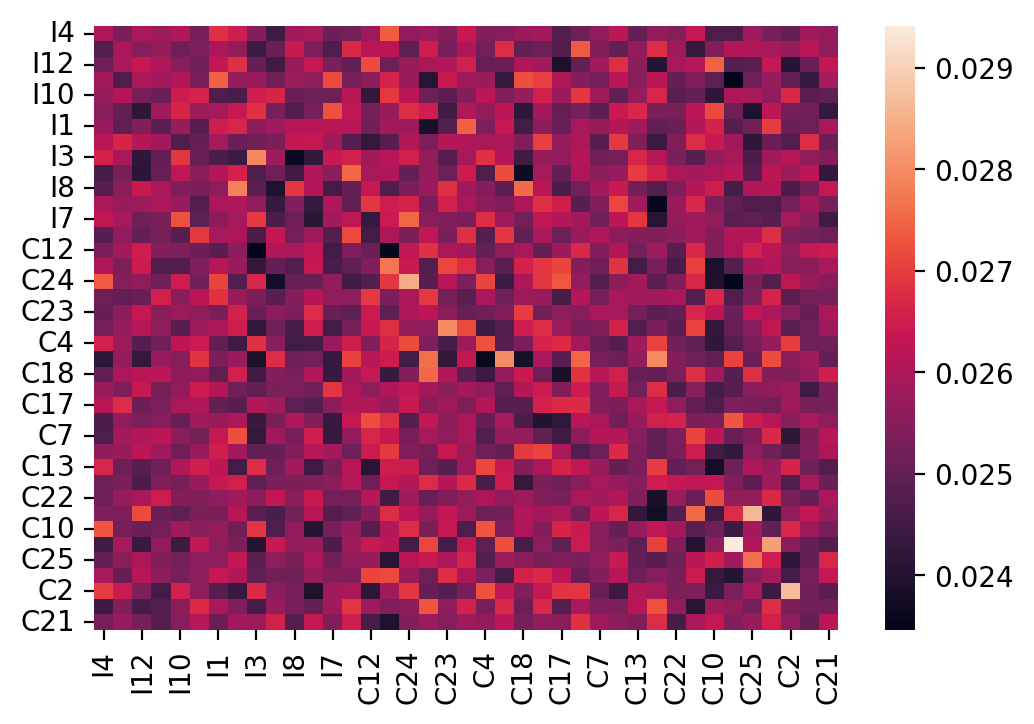

In [232]:
import seaborn as sns
from matplotlib import pyplot as plt
attention_df = pd.DataFrame(attention_score, index=feature, columns=feature)
plt.figure(dpi=200)
sns.heatmap(attention_df)